In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (16, 5)
sns.set()

In [3]:
robusta_df = pd.read_html(
    "https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=236"
)[1]

In [4]:
print(robusta_df.head())
print(robusta_df.info())

      Month  Price   Change
0  Aug 2001   0.57        -
1  Sep 2001   0.54  -5.26 %
2  Oct 2001   0.51  -5.56 %
3  Nov 2001   0.52   1.96 %
4  Dec 2001   0.54   3.85 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   235 non-null    object 
 1   Price   235 non-null    float64
 2   Change  235 non-null    object 
dtypes: float64(1), object(2)
memory usage: 5.6+ KB
None


In [5]:
df = robusta_df.copy()
df['Month'] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df = df.set_index('Month')
df.index.freq = 'MS'

df.head()

,Price,Change
Month,,
2001-08-01,0.57,-
2001-09-01,0.54,-5.26 %
2001-10-01,0.51,-5.56 %
2001-11-01,0.52,1.96 %
2001-12-01,0.54,3.85 %


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235 entries, 2001-08-01 to 2021-02-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   235 non-null    float64
 1   Change  235 non-null    object 
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


<AxesSubplot:xlabel='Month'>

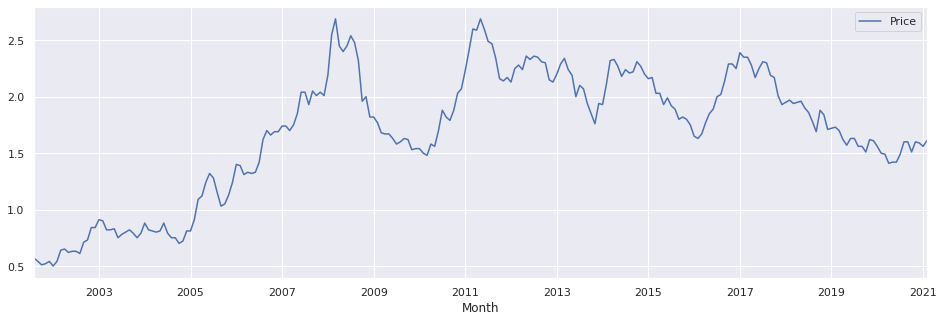

In [7]:
df.plot()

### Fitting AR model

#### Splitting into training and test set

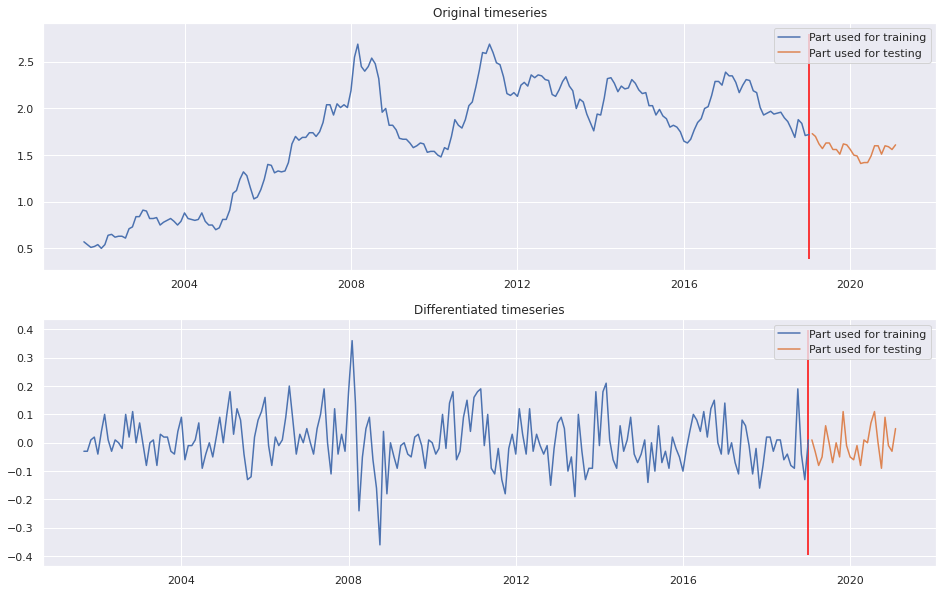

In [9]:
full_df = df.copy()
full_df["Price diff"] = full_df["Price"].diff()

df_train = full_df[:"Jan 2019"]
df_test = full_df["Feb 2019":]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].set_title("Original timeseries")
axes[0].plot(df_train.index, df_train["Price"], label="Part used for training")
axes[0].plot(df_test.index, df_test["Price"], label="Part used for testing")

axes[1].set_title("Differentiated timeseries")
axes[1].plot(df_train.index, df_train["Price diff"], label="Part used for training")
axes[1].plot(df_test.index, df_test["Price diff"], label="Part used for testing")

for ax in axes:
    y_low, y_high = ax.get_ylim()
    ax.vlines("2019-01-01", y_low, y_high, colors="red")
    ax.legend()

### Stationarity test

In [8]:
P_THRESHOLD = 0.05


def adf_test(series):
    _, p_value, *_rest = adfuller(series, autolag="AIC")
    print(
        f"p-value of ADF test is {p_value}, data is "
        f"{'stationary' if p_value < P_THRESHOLD else 'non stationary'}"
    )

In [10]:
print('----- ADF test for original timeseries -----')
adf_test(full_df['Price'])
print()
print('----- ADF test for differianted timeseries -----')
adf_test(full_df['Price diff'].dropna())

----- ADF test for original timeseries -----
p-value of ADF test is 0.18491118958549146, data is non stationary

----- ADF test for differianted timeseries -----
p-value of ADF test is 6.160421033881507e-22, data is stationary


#### Create AR model and fit to the training data

In [11]:
def fit_model(series, order):
    ar_model = ARIMA(series, order=(order, 0, 0))
    ar_fitted = ar_model.fit()

    return ar_fitted

In [12]:
def select_best_aic(series, orders_to_check=range(1, 6)):
    best_model, best_order, best_aicc = None, None, None
    for order in orders_to_check:
        fitted_model = fit_model(series, order)
        model_aicc = fitted_model.aicc
        print(f"AR({order}) AICC: {model_aicc: .4f}")
        if not best_model or model_aicc < best_aicc:
            best_model = fitted_model
            best_aicc = model_aicc
            best_order = order

    print(f"Best model is AR({best_order}) with AIC: {best_aicc: .4f}")
    return best_model, best_order

In [13]:
best_model, model_order = select_best_aic(df_train[['Price']])

print("\nBest Model summary for original dataset:")
best_model.summary()

AR(1) AICC: -400.0709
AR(2) AICC: -412.7961
AR(3) AICC: -410.7203
AR(4) AICC: -408.7327
AR(5) AICC: -406.6925
Best model is AR(2) with AIC: -412.7961

Best Model summary for original dataset:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  210
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 210.496
Date:                Sat, 01 May 2021   AIC                           -412.991
Time:                        13:29:23   BIC                           -399.603
Sample:                    08-01-2001   HQIC                          -407.579
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5138      0.315      4.811      0.000       0.897       2.131
ar.L1          1.2483      0.058     21.649      0.000       1.135       1.361
ar.L2         -0.2615      0.058     -4.516      0.000      -0.375      -0.148
sigma2         0.0077      0.001     11.696      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.49
Prob(Q):                              0.95   Prob(JB):                         0.02
Heteroskedasticity (H):               1.76   Skew:                             0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
best_model_diff, model_order_diff = select_best_aic(df_train[['Price diff']])

print("\nBest Model summary for differentiated dataset:")
best_model.summary()

AR(1) AICC: -415.4554
AR(2) AICC: -413.4879
AR(3) AICC: -411.4224
AR(4) AICC: -409.3240
AR(5) AICC: -407.4102
Best model is AR(1) with AIC: -415.4554

Best Model summary for differentiated dataset:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  210
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 210.496
Date:                Sat, 01 May 2021   AIC                           -412.991
Time:                        13:29:24   BIC                           -399.603
Sample:                    08-01-2001   HQIC                          -407.579
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5138      0.315      4.811      0.000       0.897       2.131
ar.L1          1.2483      0.058     21.649      0.000       1.135       1.361
ar.L2         -0.2615      0.058     -4.516      0.000      -0.375      -0.148
sigma2         0.0077      0.001     11.696      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.49
Prob(Q):                              0.95   Prob(JB):                         0.02
Heteroskedasticity (H):               1.76   Skew:                             0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
def forecast_using_model(model, periods):
    fitted_values = model.fittedvalues
    forecasted_values = model.forecast(periods)

    return fitted_values, forecasted_values

In [21]:
start = len(df_train)
end = len(df_train) + len(df_test)
periods = end - start
original_fitted, original_forecasted = forecast_using_model(best_model, periods)
diff_fitted, diff_forecasted = forecast_using_model(best_model_diff, periods)

In [24]:
orig_forecast_col = f"AR({model_order}) prediction on original timeseries"
diff_forecast_col = f"AR({model_order_diff}) prediction on diffrentiated timeseries"
restored_forecast_col = f"AR({model_order_diff}) prediction restored from diffrentiated timeseries"

full_df[orig_forecast_col] = pd.concat([original_fitted, original_forecasted])
full_df[diff_forecast_col] = pd.concat([diff_fitted, diff_forecasted])

<AxesSubplot:title={'center':'Prediction on diffrentiated timeseries'}, xlabel='Month'>

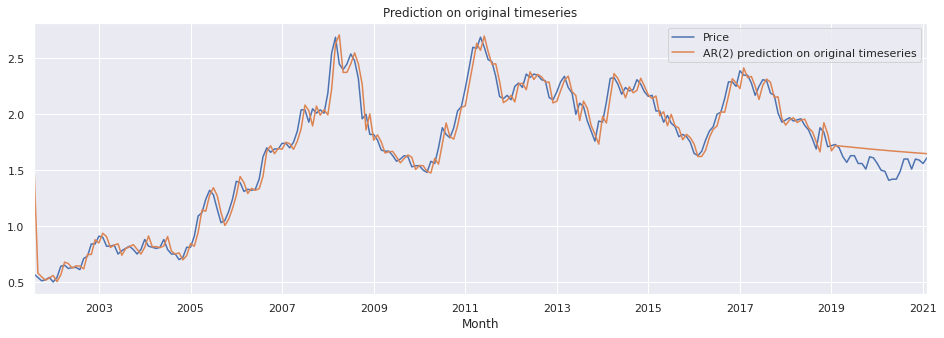

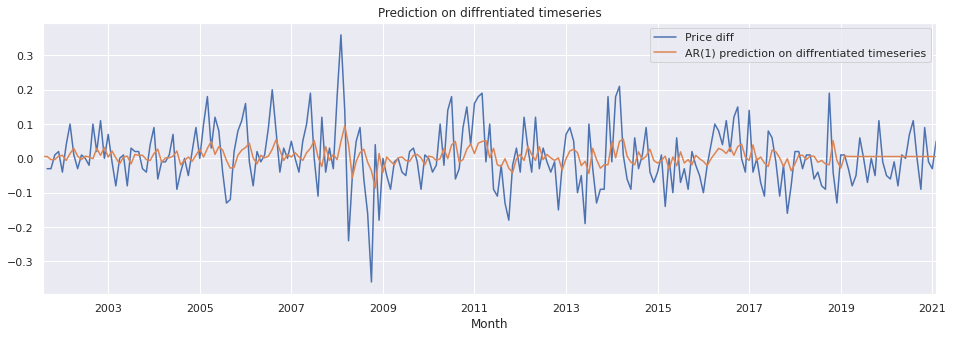

In [25]:
full_df.plot(
    y=["Price", orig_forecast_col],
    figsize=(16, 5),
    title="Prediction on original timeseries",
)
full_df.plot(
    y=["Price diff", diff_forecast_col],
    figsize=(16, 5),
    title="Prediction on diffrentiated timeseries",
)

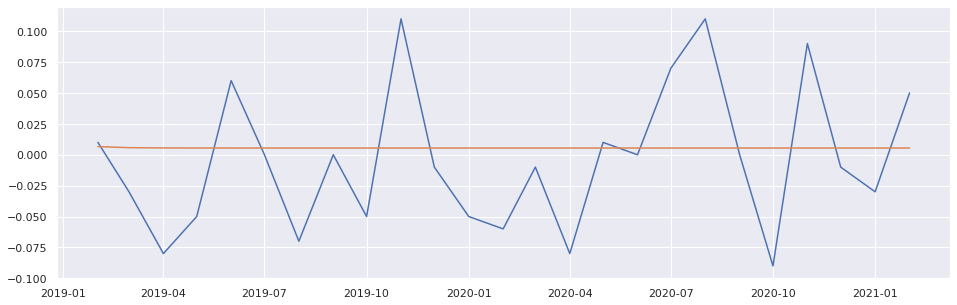

In [30]:
plt.plot(df_test['Price diff'])
plt.plot(diff_forecasted)

In [34]:
restored_forecast = diff_forecasted.copy()
restored_forecast[0] += df_test['Price'][0]
restored_forecast = restored_forecast.cumsum()

In [35]:
print("----- MSE error evaluation on original timeseries -----")
prediction_mse = np.sum((df_test["Price"] - original_forecasted).to_numpy() ** 2)
print(f"AR({model_order}) model prediction MSE: {prediction_mse:.2f}")

print("\n----- MSE error evaluation on differianted timeseries -----")
prediction_mse = np.sum((df_test["Price"] - restored_forecast).to_numpy() ** 2)
print(f"AR({model_order_diff}) model prediction MSE: {prediction_mse:.2f}")

----- MSE error evaluation on original timeseries -----
AR(2) model prediction MSE: 0.48

----- MSE error evaluation on differianted timeseries -----
AR(1) model prediction MSE: 1.68


----- Residuals statistics for original timeseries -----
AR(2) residuals mean: 0.0020593515105619773
AR(2) residuals std: 0.10931584454170888
p-value of ADF test is 3.3630153394071644e-30, data is stationary

----- Residuals statistics for diffrentiated timeseries -----
AR(1) residuals mean: 4.672886029901717e-05
AR(1) residuals std: 0.08845886016563868
p-value of ADF test is 3.3630153394071644e-30, data is stationary


Text(0.5, 1.0, 'Diffrentiated timeseries residuals')

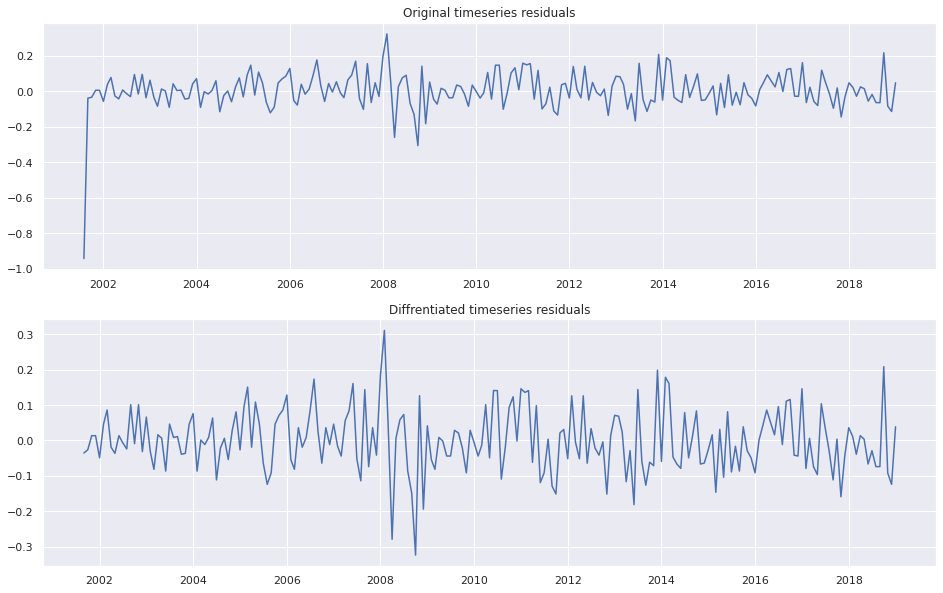

In [36]:
print("----- Residuals statistics for original timeseries -----")
print(f"AR({model_order}) residuals mean: {best_model.resid.mean()}")
print(f"AR({model_order}) residuals std: {best_model.resid.std()}")
adf_test(best_model.resid)

print("\n----- Residuals statistics for diffrentiated timeseries -----")
print(f"AR({model_order_diff}) residuals mean: {best_model_diff.resid.mean()}")
print(f"AR({model_order_diff}) residuals std: {best_model_diff.resid.std()}")
adf_test(best_model.resid)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(best_model.resid)
axes[0].set_title('Original timeseries residuals')

axes[1].plot(best_model_diff.resid);
axes[1].set_title('Diffrentiated timeseries residuals')